In [3]:
!pip install medmnist
!pip install torchmetrics

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 115.9/115.9 kB 12.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 983.2/983.2 kB 51.0 MB/s eta 0:00:00


In [4]:
# Deep learning packages
import torch
import torch.nn as nn
from torch import utils
from torch import optim
from torch import device
from torch import inference_mode
from torch.utils.data import DataLoader
import torchvision
from torchvision import transforms
from torchmetrics import ConfusionMatrix

# Data management and Plotting
import numpy
import tqdm
from tqdm.auto import tqdm
import matplotlib.pyplot as plt
from textwrap import wrap
from timeit import default_timer as timer
import mlxtend
from mlxtend.plotting import plot_confusion_matrix

# Import MedMNIST
import medmnist
from medmnist import INFO, Evaluator
print(f"MedMNIST v{medmnist.__version__} @ {medmnist.HOMEPAGE}")

MedMNIST v3.0.2 @ https://github.com/MedMNIST/MedMNIST/


In [5]:
# Get CPU or GPU device for training
device = "cuda" if torch.cuda.is_available() else "cpu"
device = torch.device(device)

In [6]:
## Download and Split Datasets
data_flag = 'bloodmnist'

# Get data info
info = INFO[data_flag]
DataClass = getattr(medmnist, info['python_class'])

# Number of image channels
n_channels = info['n_channels']
print(f"number of channels: {n_channels}")

# Number of classes
n_classes = len(info['label'])
print(f"number of classes: {n_classes}")

# Number of hidden neurons in model
hidden_units = 128
print(f"number of hidden units: {hidden_units}")

# Get the class names from the dataset
class_names = info['label']
print(f"class names: {class_names}")

# Transform to feed to NN
data_transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize(mean=[.5], std=[.5])
    ])

# Data split
train_data = DataClass(split='train', transform=data_transform, download=True)
val_data = DataClass(split='val', transform=data_transform, download=True)
test_data = DataClass(split='test', transform=data_transform, download=True)

# Data into dataloader form
BATCH_SIZE = 128
train_dataloader = DataLoader(dataset=train_data, batch_size=BATCH_SIZE, shuffle=True)
val_dataloader = DataLoader(dataset=val_data, batch_size=BATCH_SIZE, shuffle=True)
test_dataloader = DataLoader(dataset=test_data, batch_size=BATCH_SIZE, shuffle=True)

number of channels: 3
number of classes: 8
number of hidden units: 128
class names: {'0': 'basophil', '1': 'eosinophil', '2': 'erythroblast', '3': 'immature granulocytes(myelocytes, metamyelocytes and promyelocytes)', '4': 'lymphocyte', '5': 'monocyte', '6': 'neutrophil', '7': 'platelet'}


100%|██████████| 35.5M/35.5M [00:03<00:00, 11.0MB/s]


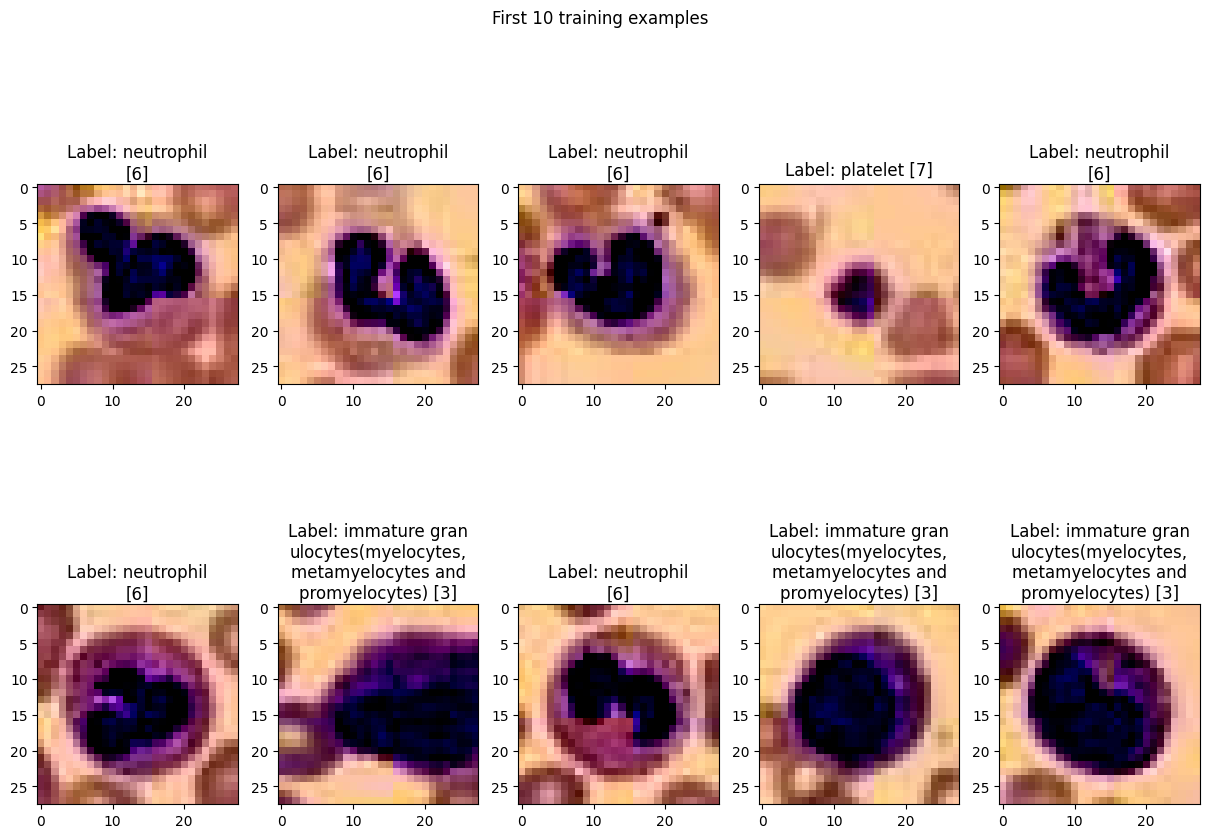

In [7]:
# Plot some data samples with labels
fig, axs = plt.subplots(nrows=2, ncols=5, figsize=(15, 10))
axs = axs.ravel()

# Iterate through images in train dataloader
i = 0
while i < len(axs):
  images, labels = next(iter(train_dataloader))
  axs[i].imshow(images[0].permute(1, 2, 0).numpy())
  axs[i].set_title("\n".join(wrap(f"Label: {class_names[str(labels[0].item())]}"+ " [" + str(labels[0].item())+ "]", 20)), wrap=True)
  i += 1

plt.suptitle(f"First {len(axs)} training examples")
plt.show()

# Save to SVG for OverLeaf (not used in BDS capstone)
fig.savefig("train_examples.svg")

In [8]:
## Making the CNN
class cnn(torch.nn.Module):
    def __init__(self, input_shape: int, hidden_units: int, output_shape: int):
        super().__init__()

        # Layer 1: Conv layer with BatchNorm and ReLU
        self.layer1 = nn.Sequential(
            nn.Conv2d(in_channels=input_shape,
                      out_channels=hidden_units,
                      kernel_size=3,
                      padding=1),
            nn.BatchNorm2d(hidden_units),
            nn.ReLU())

        # Layer 2: Another Conv layer followed by BatchNorm, ReLU, and MaxPooling
        self.layer2 = nn.Sequential(
            nn.Conv2d(in_channels=hidden_units,
                      out_channels=hidden_units,
                      kernel_size=3,
                      padding=1),
            nn.BatchNorm2d(hidden_units),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2,
                         stride=2))

        # Layer 3: Conv layer with 4x more filters, followed by BatchNorm and ReLU
        self.layer3 = nn.Sequential(
            nn.Conv2d(in_channels=hidden_units,
                      out_channels=hidden_units*4,
                      kernel_size = 3,
                      padding=1),
            nn.BatchNorm2d(hidden_units*4),
            nn.ReLU()
        )

        # Layer 4: Similar Conv layer followed by BatchNorm and ReLU
        self.layer4 = nn.Sequential(
            nn.Conv2d(in_channels=hidden_units*4,
                      out_channels=hidden_units*4,
                      kernel_size=3,
                      padding=1),
            nn.BatchNorm2d(hidden_units*4),
            nn.ReLU())

        self.layer5 = nn.Sequential(
            nn.Conv2d(in_channels=hidden_units*4,
                      out_channels=hidden_units*4,
                      kernel_size=3,
                      padding=1),
            nn.BatchNorm2d(hidden_units*4),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2,
                         stride=2))

        self.fc = nn.Sequential(
            nn.Linear(hidden_units*4 * 7 * 7, hidden_units*8),
            nn.ReLU(),
            nn.Linear(hidden_units*8, hidden_units*8),
            nn.ReLU(),
            nn.Linear(hidden_units*8, n_classes))

    def forward(self, x):
        x = self.layer1(x)
        x = self.layer2(x)
        x = self.layer3(x)
        x = self.layer4(x)
        x = self.layer5(x)
        x = torch.flatten(x, 1)                      #flatten the output of the last conv layer
        x = self.fc(x)                      #pass the output through the fully connected layer
        return x

# Define Model and send to selected device
model = cnn(input_shape=n_channels,
            hidden_units=hidden_units,
            output_shape=n_classes).to(device) # initialize the cnn model

# Setup loss and optimizer
loss_fn = nn.CrossEntropyLoss()
optimizer = torch.optim.SGD(model.parameters(), lr=0.001, momentum=0.9) # Gradient Descent with standard learning rate .001

model # View Model

cnn(
  (layer1): Sequential(
    (0): Conv2d(3, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
  )
  (layer2): Sequential(
    (0): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
    (3): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (layer3): Sequential(
    (0): Conv2d(128, 512, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
  )
  (layer4): Sequential(
    (0): Conv2d(512, 512, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
  )
  (layer5): Sequential(
    (0): Conv2d(512, 512, kernel_size=(3, 3),

In [9]:
# Define training loop functions
def train_step(model: torch.nn.Module,
               data_loader: torch.utils.data.DataLoader,
               loss_fn: torch.nn.Module,
               optimizer: torch.optim.Optimizer,
               accuracy_fn,
               device: torch.device = device):

    train_loss, train_acc = 0, 0
    model.to(device)

    for batch, (X, y) in enumerate(data_loader):

        y = y.squeeze().long() # need to change target shape for this medmnist data
        X, y = X.to(device), y.to(device) # Send data to selected device

        # 1. Forward pass
        y_logits = model(X)
        y_pred = torch.argmax(y_logits, dim=1)

        # 2. loss and accuracy
        loss = loss_fn(y_logits, y)
        train_loss += loss
        train_acc += accuracy_fn(y, y_pred)

        # 3. Set gradients to zero for next iteration
        optimizer.zero_grad()

        # 4. Compute gradients
        loss.backward()

        # 5. Update parameters
        optimizer.step()

    # Calculate loss and accuracy per epoch
    train_loss /= len(data_loader)
    train_acc /= len(data_loader)

    return train_loss, train_acc

# Define test loop functions
def test_step(data_loader: torch.utils.data.DataLoader,
              model: torch.nn.Module,
              loss_fn: torch.nn.Module,
              accuracy_fn,
              device: torch.device = device):

    test_loss, test_acc = 0, 0
    model.to(device)

    model.eval() # eval mode for testing
    with torch.inference_mode(): # Inference context manager
        for X, y in data_loader:
            y = y.squeeze().long() # Again, need to change target shape for this medmnist data
            X, y = X.to(device), y.to(device) # Send data to selected device

            # 1. Forward pass
            y_logits = model(X)
            y_pred = torch.argmax(y_logits, dim=1)

            # 2. Calculate loss and accuracy
            test_loss += loss_fn(y_logits, y)
            test_acc += accuracy_fn(y, y_pred)

        # Adjust metrics and print out
        test_loss /= len(data_loader)
        test_acc /= len(data_loader)

        return test_loss, test_acc

# Define evaluation loop functions
def eval_func(data_loader: torch.utils.data.DataLoader,
              model: torch.nn.Module,
              loss_fn: torch.nn.Module,
              accuracy_fn,
              device: torch.device = device):

    eval_loss, eval_acc = 0, 0
    model.to(device)

    model.eval()
    y_preds = []
    y_targets = []
    with torch.inference_mode():
        for batch, (X, y) in tqdm(enumerate(data_loader)):

            y = y.squeeze().long() # Changes targer shape
            X, y = X.to(device), y.to(device)   # Send data to selected device

            # Forward pass
            eval_pred = model(X)

            # Find loss and accuracy
            eval_loss += loss_fn(eval_pred, y)
            eval_labels =  torch.argmax(eval_pred, dim=1)
            eval_acc += accuracy_fn(y, eval_pred)

            # Add prediction and target labels to list
            y_preds.append(eval_labels)
            y_targets.append(y)

        # Scale loss and acc
        eval_loss /= len(data_loader)
        eval_acc /= len(data_loader)

        # Put predictions on CPU for evaluation steps
        y_preds=torch.cat(y_preds).cpu()
        y_targets=torch.cat(y_targets).cpu()

        return {"model_name": model.__class__.__name__,
                "loss": eval_loss.item(),
                "accuracy": eval_acc,
                "predictions": y_preds,
                "targets": y_targets}

# Function to calculate model run time
def print_train_time(start: float, end: float, device: torch.device = None):
    total_time = end - start
    print(f"Train time on {device}: {total_time:.3f} seconds")
    return total_time

# Accuracy calculation function
def accuracy_fn(y_true, y_pred):
    # Check if y_pred needs argmax (i.e., if it's raw logits)
    if y_pred.ndim > 1:
        y_pred = torch.argmax(y_pred, dim=1)
    correct = torch.eq(y_true, y_pred).sum().item()
    acc = (correct / len(y_pred)) * 100
    return acc

In [10]:
## Train and Test

# Set random seeds
torch.manual_seed(42)

# Measure Time
train_time_start_model = timer()
iteration_loss_list = []
iteration_accuracy_list = []

# set parameters
epochs = 10
best_loss = 10

# call train and test function
for epoch in tqdm(range(epochs)):
    train_loss, train_acc = train_step(model=model,
                                       data_loader=train_dataloader,
                                       loss_fn=loss_fn,
                                       optimizer=optimizer,
                                       accuracy_fn=accuracy_fn,
                                       device=device)

    test_loss, test_acc = test_step(data_loader=val_dataloader,
                                    model=model,
                                    loss_fn=loss_fn,
                                    accuracy_fn=accuracy_fn,
                                    device=device)

    for iteration, (x, y) in enumerate(train_dataloader):
        iteration_loss_list.append(train_loss.item())
        iteration_accuracy_list.append(train_acc)


    print(f"Epoch: {epoch} | Training loss: {train_loss:.3f} | Training acc: {train_acc:.2f} | Test loss: {test_loss:.3f} | Test acc: {test_acc:.2f}")

    # save best model instance

    if test_loss < best_loss:
        best_loss = test_loss
        print(f"Saving best model for epoch: {epoch}")
        torch.save(obj=model.state_dict(),
                   f="./model.pth")


train_time_end_model = timer()
total_train_time_model = print_train_time(start=train_time_start_model,
                                           end=train_time_end_model,
                                           device=device)

  0%|          | 0/10 [00:00<?, ?it/s]

Epoch: 0 | Training loss: 0.955 | Training acc: 70.08 | Test loss: 0.448 | Test acc: 84.26
Saving best model for epoch: 0
Epoch: 1 | Training loss: 0.432 | Training acc: 84.32 | Test loss: 0.364 | Test acc: 85.71
Saving best model for epoch: 1
Epoch: 2 | Training loss: 0.317 | Training acc: 88.82 | Test loss: 0.291 | Test acc: 90.03
Saving best model for epoch: 2
Epoch: 3 | Training loss: 0.247 | Training acc: 91.17 | Test loss: 0.246 | Test acc: 91.57
Saving best model for epoch: 3
Epoch: 4 | Training loss: 0.207 | Training acc: 92.38 | Test loss: 0.246 | Test acc: 90.89
Epoch: 5 | Training loss: 0.155 | Training acc: 94.50 | Test loss: 0.211 | Test acc: 92.80
Saving best model for epoch: 5
Epoch: 6 | Training loss: 0.132 | Training acc: 95.32 | Test loss: 0.174 | Test acc: 94.31
Saving best model for epoch: 6
Epoch: 7 | Training loss: 0.091 | Training acc: 97.09 | Test loss: 0.212 | Test acc: 92.22
Epoch: 8 | Training loss: 0.086 | Training acc: 97.01 | Test loss: 0.160 | Test acc: 9

In [11]:
# Load model
loaded_model = cnn(input_shape=n_channels,
                   hidden_units=hidden_units,
                   output_shape=n_classes).to(device)

loaded_model.load_state_dict(torch.load(f="./model.pth"))

# get results
model_results = eval_func(data_loader=test_dataloader, # Call eval_func with the test_dataloader
                          model=loaded_model,
                          loss_fn=loss_fn,
                          accuracy_fn=accuracy_fn,
                          device=device)

model_results

0it [00:00, ?it/s]

{'model_name': 'cnn',
 'loss': 0.17496465146541595,
 'accuracy': 94.1731381919554,
 'predictions': tensor([3, 1, 1,  ..., 3, 6, 6]),
 'targets': tensor([3, 1, 1,  ..., 3, 6, 6])}

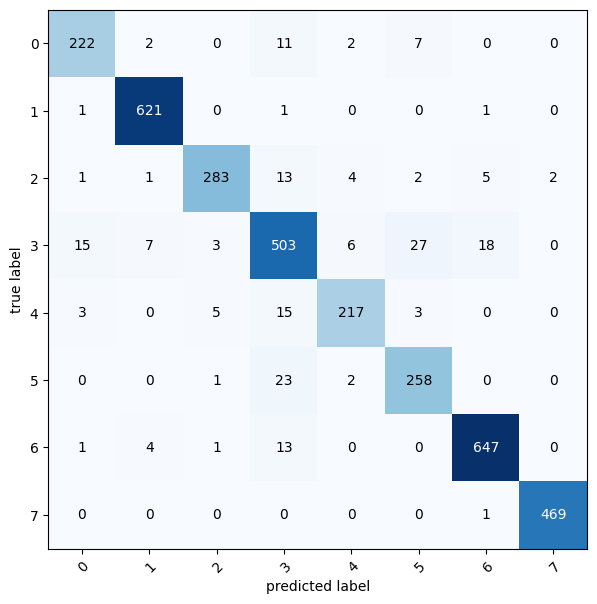

In [12]:
# Get Model predictions and true targets
y_targets = model_results['targets']
y_preds = model_results['predictions']

# Setup confusion matrix
confmat = ConfusionMatrix(task="multiclass", num_classes=len(class_names))
confmat_tensor = confmat(preds=y_preds,
                         target=y_targets)

# Plot the confusion matrix
fix, ax = plot_confusion_matrix(
    conf_mat=confmat_tensor.numpy(),
    class_names=class_names,
    figsize=(10, 7)
)

# Save confusion matrix to SVG
fig.savefig("confusion_matrix.svg")


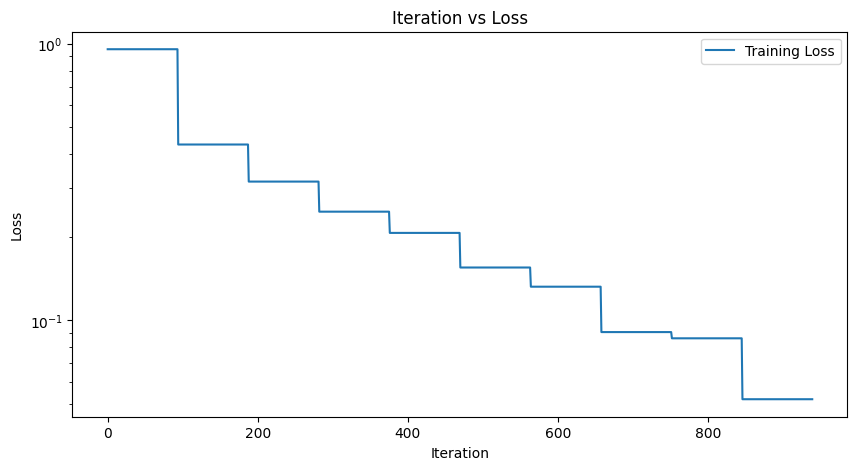

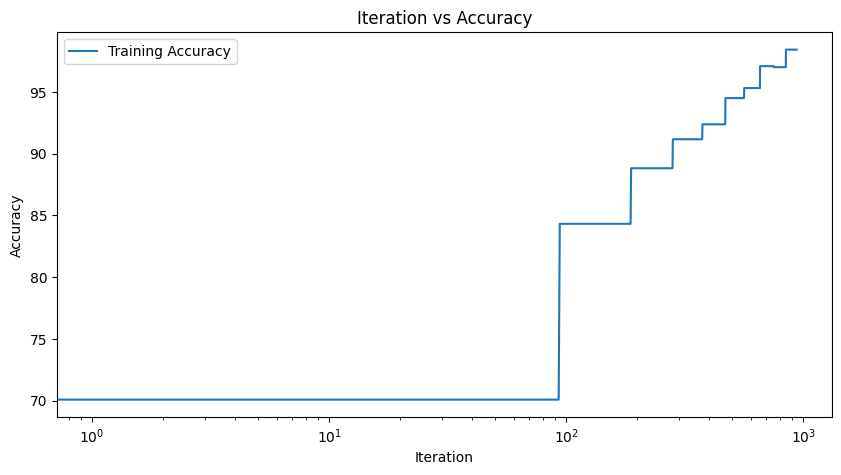

In [13]:
# Plot iteration vs loss
plt.figure(figsize=(10, 5))
plt.semilogy(iteration_loss_list, label='Training Loss')
plt.xlabel('Iteration')
plt.ylabel('Loss')
plt.title('Iteration vs Loss')
plt.legend()
plt.show()
# Save to svg
fig.savefig("iteration_vs_loss.svg")

# Plot iteration vs accuracy
plt.figure(figsize=(10, 5))
plt.semilogx(iteration_accuracy_list, label='Training Accuracy')
plt.xlabel('Iteration')
plt.ylabel('Accuracy')
plt.title('Iteration vs Accuracy')
plt.legend()
plt.show()

# save Both plots to svg files
fig.savefig("iteration_vs_acc.svg")

In [14]:
torch.save(loaded_model.state_dict(), "medmnist_cnn_pytorch.ckpt")

In [15]:
def visualize_and_predict(model, device, data_loader):
    model.eval()
    with torch.no_grad():
        # Extract the first batch of images and labels
        data, target = next(iter(data_loader))
        # Select the first image and label
        img, label = data[0], target[0]

        # Visualize the image with a title indicating predicted label and actual label
        plt.imshow(img.permute(1, 2, 0).numpy())
        plt.title(f"Predicted: {class_names[str(label.item())]}\nActual: {class_names[str(label.item())]}")
        plt.show()

        # Run inference
        img = img.to(device)
        output = model(img.unsqueeze(0))  # Add batch dimension
        pred = torch.argmax(output, dim=1)

        print(f"\n".join(wrap(f"Predicted Label: {class_names[str(pred.item())]}"+ " [" + str(pred.item())+ "]", 20)))

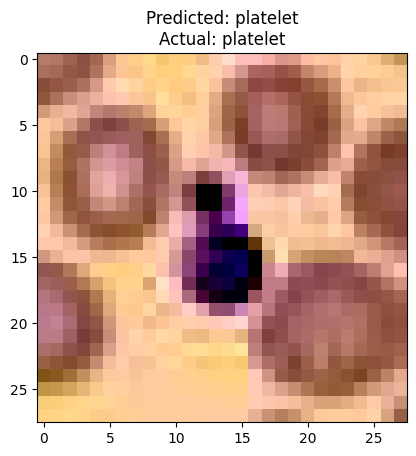

Predicted Label:
platelet [7]


In [16]:
visualize_and_predict(loaded_model, device, test_dataloader)

In [17]:
!pip install torchviz
!apt-get install graphviz -y

Reading package lists... Done
Building dependency tree... Done
Reading state information... Done
graphviz is already the newest version (2.42.2-6ubuntu0.1).
0 upgraded, 0 newly installed, 0 to remove and 38 not upgraded.


In [20]:
import torch
from torchviz import make_dot
class cnn(torch.nn.Module):
    def __init__(self, input_shape: int, hidden_units: int, output_shape: int):
        super().__init__()

        # Layer 1: Conv layer with BatchNorm and ReLU
        self.layer1 = nn.Sequential(
            nn.Conv2d(in_channels=input_shape,
                      out_channels=hidden_units,
                      kernel_size=3,
                      padding=1),
            nn.BatchNorm2d(hidden_units),
            nn.ReLU())

        # Layer 2: Another Conv layer followed by BatchNorm, ReLU, and MaxPooling
        self.layer2 = nn.Sequential(
            nn.Conv2d(in_channels=hidden_units,
                      out_channels=hidden_units,
                      kernel_size=3,
                      padding=1),
            nn.BatchNorm2d(hidden_units),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2,
                         stride=2))

        # Layer 3: Conv layer with 4x more filters, followed by BatchNorm and ReLU
        self.layer3 = nn.Sequential(
            nn.Conv2d(in_channels=hidden_units,
                      out_channels=hidden_units*4,
                      kernel_size = 3,
                      padding=1),
            nn.BatchNorm2d(hidden_units*4),
            nn.ReLU()
        )

        # Layer 4: Similar Conv layer followed by BatchNorm and ReLU
        self.layer4 = nn.Sequential(
            nn.Conv2d(in_channels=hidden_units*4,
                      out_channels=hidden_units*4,
                      kernel_size=3,
                      padding=1),
            nn.BatchNorm2d(hidden_units*4),
            nn.ReLU())

        self.layer5 = nn.Sequential(
            nn.Conv2d(in_channels=hidden_units*4,
                      out_channels=hidden_units*4,
                      kernel_size=3,
                      padding=1),
            nn.BatchNorm2d(hidden_units*4),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2,
                         stride=2))

        self.fc = nn.Sequential(
            nn.Linear(hidden_units*4 * 7 * 7, hidden_units*8),
            nn.ReLU(),
            nn.Linear(hidden_units*8, hidden_units*8),
            nn.ReLU(),
            nn.Linear(hidden_units*8, n_classes))

    def forward(self, x):
        x = self.layer1(x)
        x = self.layer2(x)
        x = self.layer3(x)
        x = self.layer4(x)
        x = self.layer5(x)
        x = torch.flatten(x, 1)                      #flatten the output of the last conv layer
        x = self.fc(x)                      #pass the output through the fully connected layer
        return x

# 2. Create a dummy input tensor that matches your image size
# (1 image, 3 color channels, 28x28 pixels)
dummy_input = torch.randn(1, 3, 28, 28).to(device) # Move dummy_input to the same device as the model


# 3. Generate the graph by making a forward pass
y = model(dummy_input)
graph = make_dot(y, params=dict(model.named_parameters()))

# 4. Render and save the graph
# This will create a file named 'cnn_architecture.jpg' in your environment
graph.render("cnn_architecture", format="jpg", cleanup=True)

print("CNN architecture diagram saved as cnn_architecture.pdf")

CNN architecture diagram saved as cnn_architecture.pdf
